Welcome

In [1]:
## Loads required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
##
USA = pd.read_csv("USA.csv"); 
USA = np.array(USA)
cities = pd.read_csv("cities.csv"); 
cities_names = cities.loc[:,"City"]

population = np.array(cities['POPESTIMATE2017'])
trips = np.array(cities['TRIPS'])
landarea = np.array(cities['LANDAREA'])
density = population/landarea
tripspc = trips/population

cities_xy = cities.loc[:,["X","Y"]] #
cities_xy = np.array(cities_xy)
cities_xy =cities_xy[~np.isnan(tripspc)]
population = population[~np.isnan(tripspc)]
cities_names = cities_names[~np.isnan(tripspc)]
tripspc = tripspc[~np.isnan(tripspc)]
cities_names=list(cities_names)
population = np.array(population,dtype='float64')
##

In [3]:
##
# Number of connections
webn = 1;
# Determine best connections for topc number of cities
topc = 5;
linkage = 5;
distance_threshold=300 # Miles before exponentially increasing issues
a=.5 #Distance factor
b=.45#Population factor
c=.05 #transit factor
d = a+b+c; # sum of factors

In [4]:
##
population = np.array(population,dtype='float64')
population_raw = np.copy(population)
population = population/np.max(population)
cities_distances = np.zeros([np.size(cities_names),np.size(cities_names)])
cities_distances_mi = np.zeros([np.size(cities_names),np.size(cities_names)])
for i in np.arange(np.size(cities_names)):
    # find distance from city a to others
    cities_distances[i,:]=np.sqrt(np.sum(np.square(cities_xy*68.5-cities_xy[i,:]*68.5),axis=1))
    cities_distances_mi[i,:]=np.sqrt(np.sum(np.square(cities_xy*68.5-cities_xy[i,:]*68.5),axis=1))
    dt = distance_threshold/np.max(cities_distances[i,:])
    cities_distances[i,:] = cities_distances[i,:]/np.max(cities_distances[i,:])
    cities_distances[i,:]=(cities_distances[i,:]/dt+np.heaviside(cities_distances[i,:]-dt,1)*(cities_distances[i,:]+20)) #(cities_distances[:,i])**2+10
    cities_distances[i,:]=cities_distances[i,:]/np.max(cities_distances[i,:])    
cities_distances[np.arange(np.size(cities_names)),np.arange(np.size(cities_names))]=np.inf
cities_distances_f=np.copy(cities_distances)
#transit normalization
tripspc_raw =np.copy(tripspc)
tripspc = tripspc/np.max(tripspc)
#transit decay factor
tripspc = tripspc**(1/4)
#population decay factor
population = population**(1/4)
##

Text(0,0.5,'score (0-worst, 1-best)')

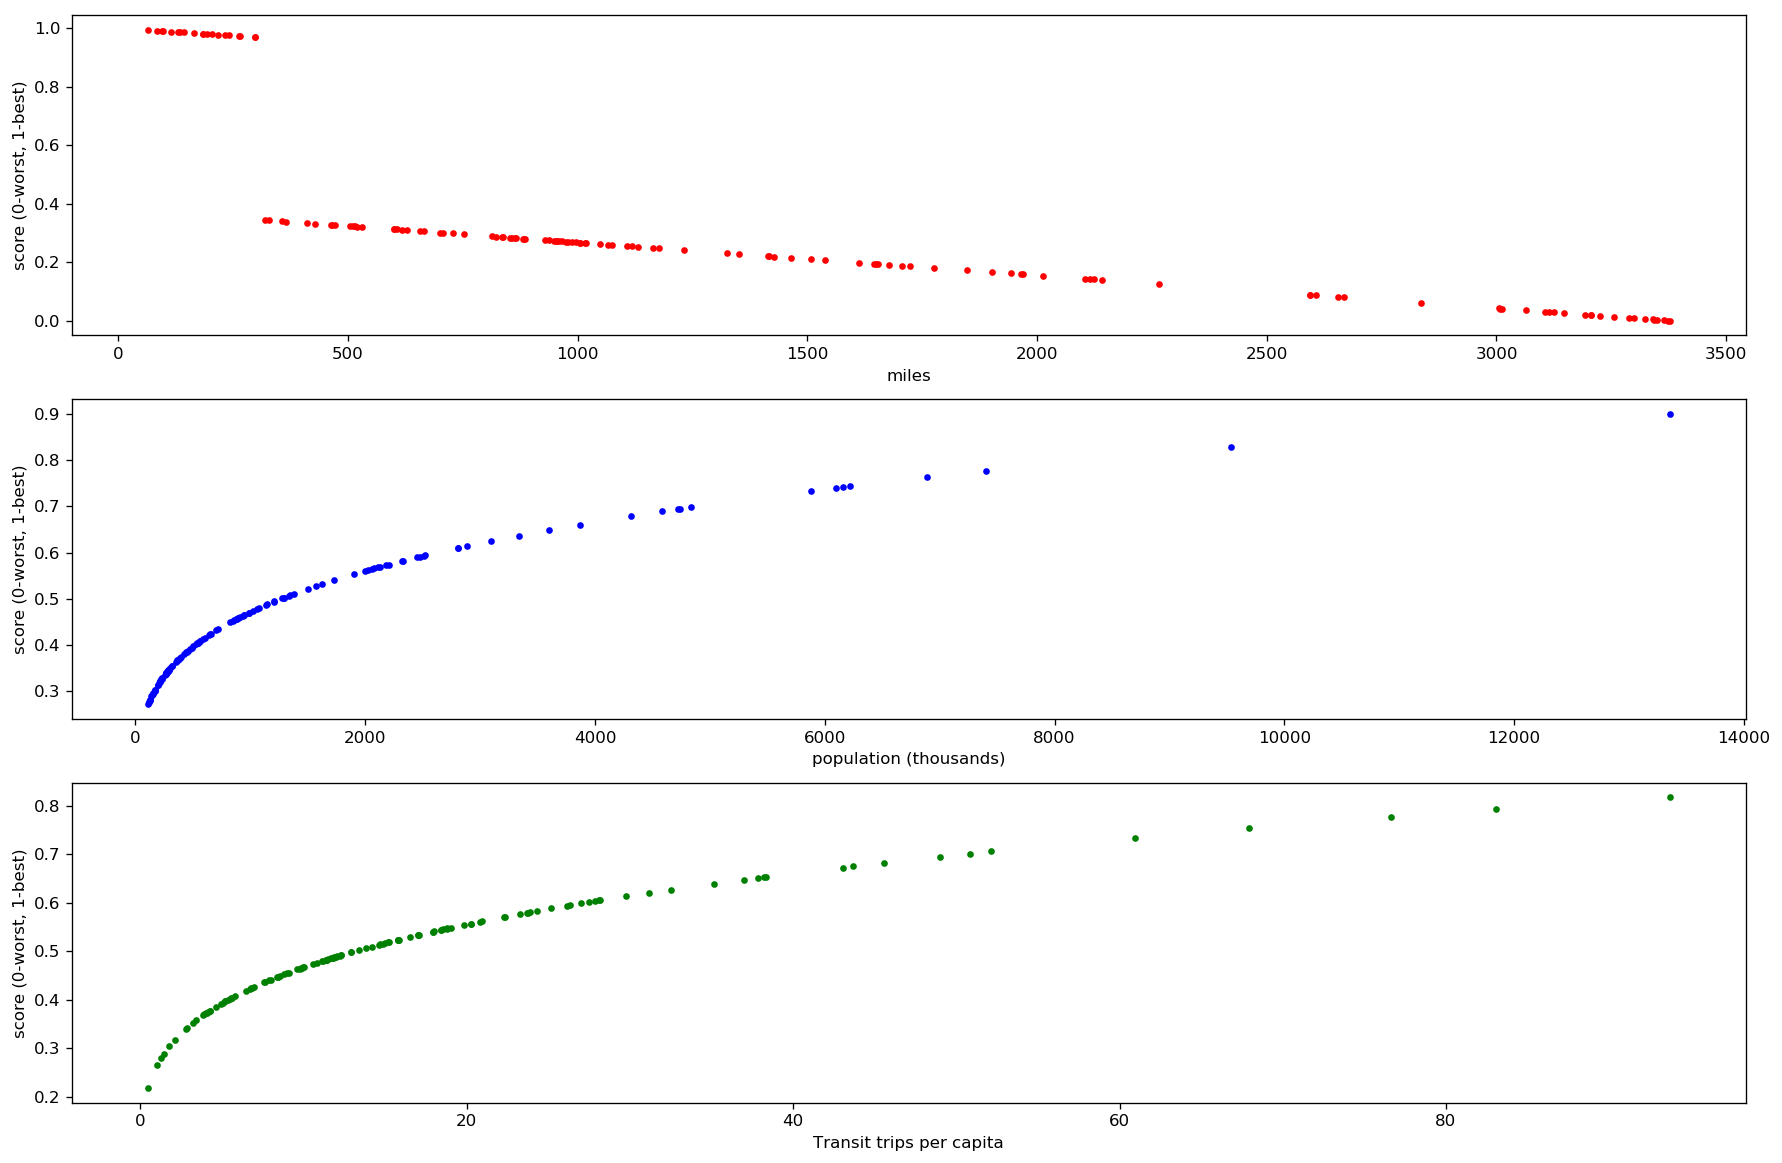

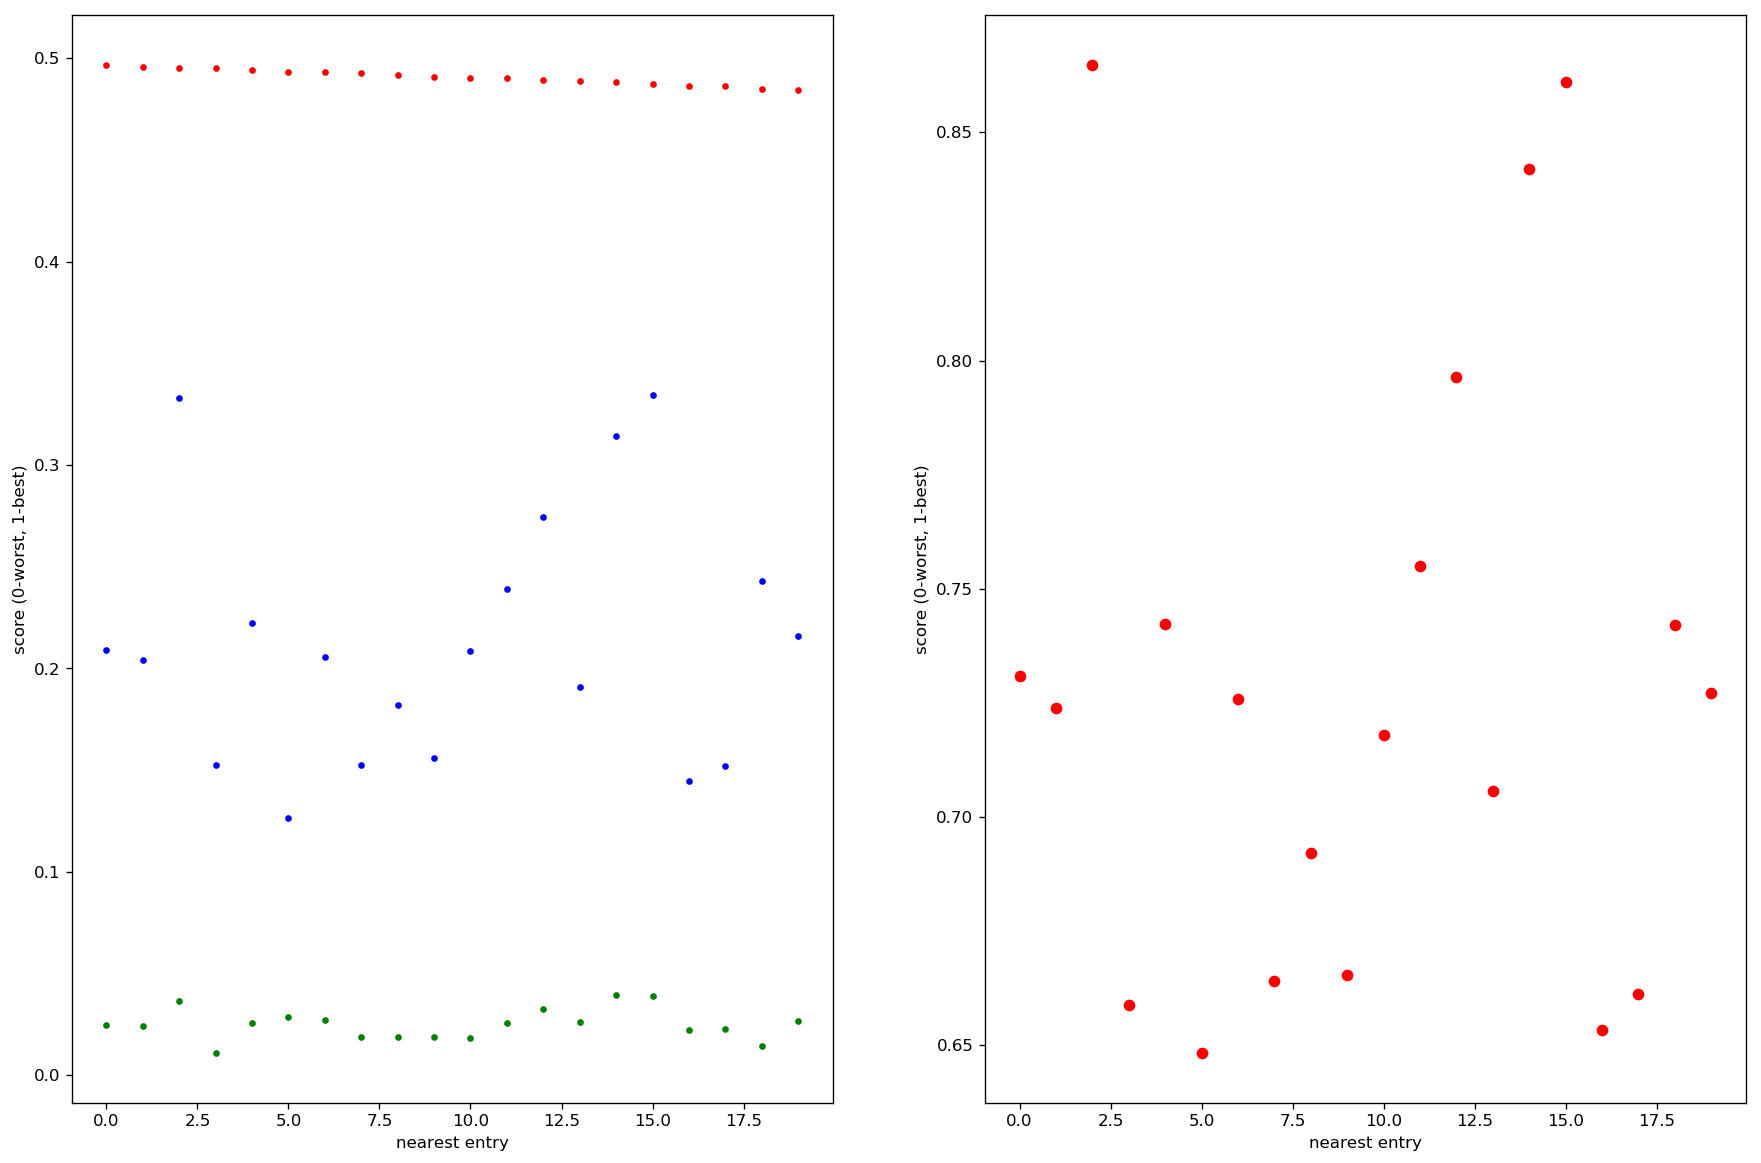

In [5]:
## Plotting of score methodology
pltrrr = 30

plt.figure(2,figsize=(18, 12), dpi= 120, facecolor='w', edgecolor='k')
plt.clf()
plt.subplot(311)
plt.plot(cities_distances_mi[0,1:],1-cities_distances[0,1:],'r.')
plt.xlabel('miles')
plt.ylabel('score (0-worst, 1-best)')
plt.subplot(312)
plt.plot(population_raw[1:]/1000,population[1:],'b.')
plt.xlabel('population (thousands)')
plt.ylabel('score (0-worst, 1-best)')
plt.subplot(313)
plt.plot(tripspc_raw[1:],tripspc[1:],'g.')
plt.xlabel('Transit trips per capita')
plt.ylabel('score (0-worst, 1-best)')


# NYC the closest 20
cities_distances_e = np.copy(cities_distances[0,:])
exn = np.zeros(20,dtype='int64')
for i in np.arange(20):
    exn[i] = np.argmin(cities_distances_e)
    cities_distances_e[exn[i]]=np.inf
    
plt.figure(6,figsize=(18, 12), dpi= 120, facecolor='w', edgecolor='k')
plt.clf()
plt.subplot(121)
plt.plot((1-cities_distances[0,exn])*a,'r.',label='distance score')
plt.plot(b*population[exn],'b.',label='population score')
plt.plot(c*tripspc[exn],'g.',label='trips score')
plt.xlabel('nearest entry')
plt.ylabel('score (0-worst, 1-best)')
plt.subplot(122)
plt.plot(a*(1-cities_distances[0,exn])+b*population[exn]+c*tripspc[exn],'ro',label='trips score')
plt.xlabel('nearest entry')
plt.ylabel('score (0-worst, 1-best)')

In [6]:
trackn = topc*webn**linkage
tracks = np.zeros([trackn,linkage],dtype='int64')

starting = np.arange(topc,dtype='int64')
#starting = np.array([34,25],dtype='int64')
#starting = np.array([49,49,49,49],dtype='int64')
#starting = np.array([0,0,0,0],dtype='int64')
for i in np.arange(topc):
    tracks[np.arange(i,trackn,topc),0]=starting[i]

score = np.zeros(trackn)
for i in np.arange(trackn):
    pop=np.copy(population)   
    tripper = np.copy(tripspc)
    for j in np.arange(linkage-1):
        pop[tracks[i,j]]=-np.inf
        tripper[tracks[i,j]] = -np.inf
        model= ((a+b+c)-(1-cities_distances[tracks[i,j],:])*a-pop*b-tripper*c)
        n = np.argmin(model)
        
        score[i] += np.min(model)
        tracks[i,j+1] = n
        cities_distances[tracks[i,j],n]=np.inf
        cities_distances[n,tracks[i,j]]=np.inf

raw_score = np.copy(score)
score = score-np.min(score)
score = score/np.max(score)

cities_distances=np.copy(cities_distances_f)

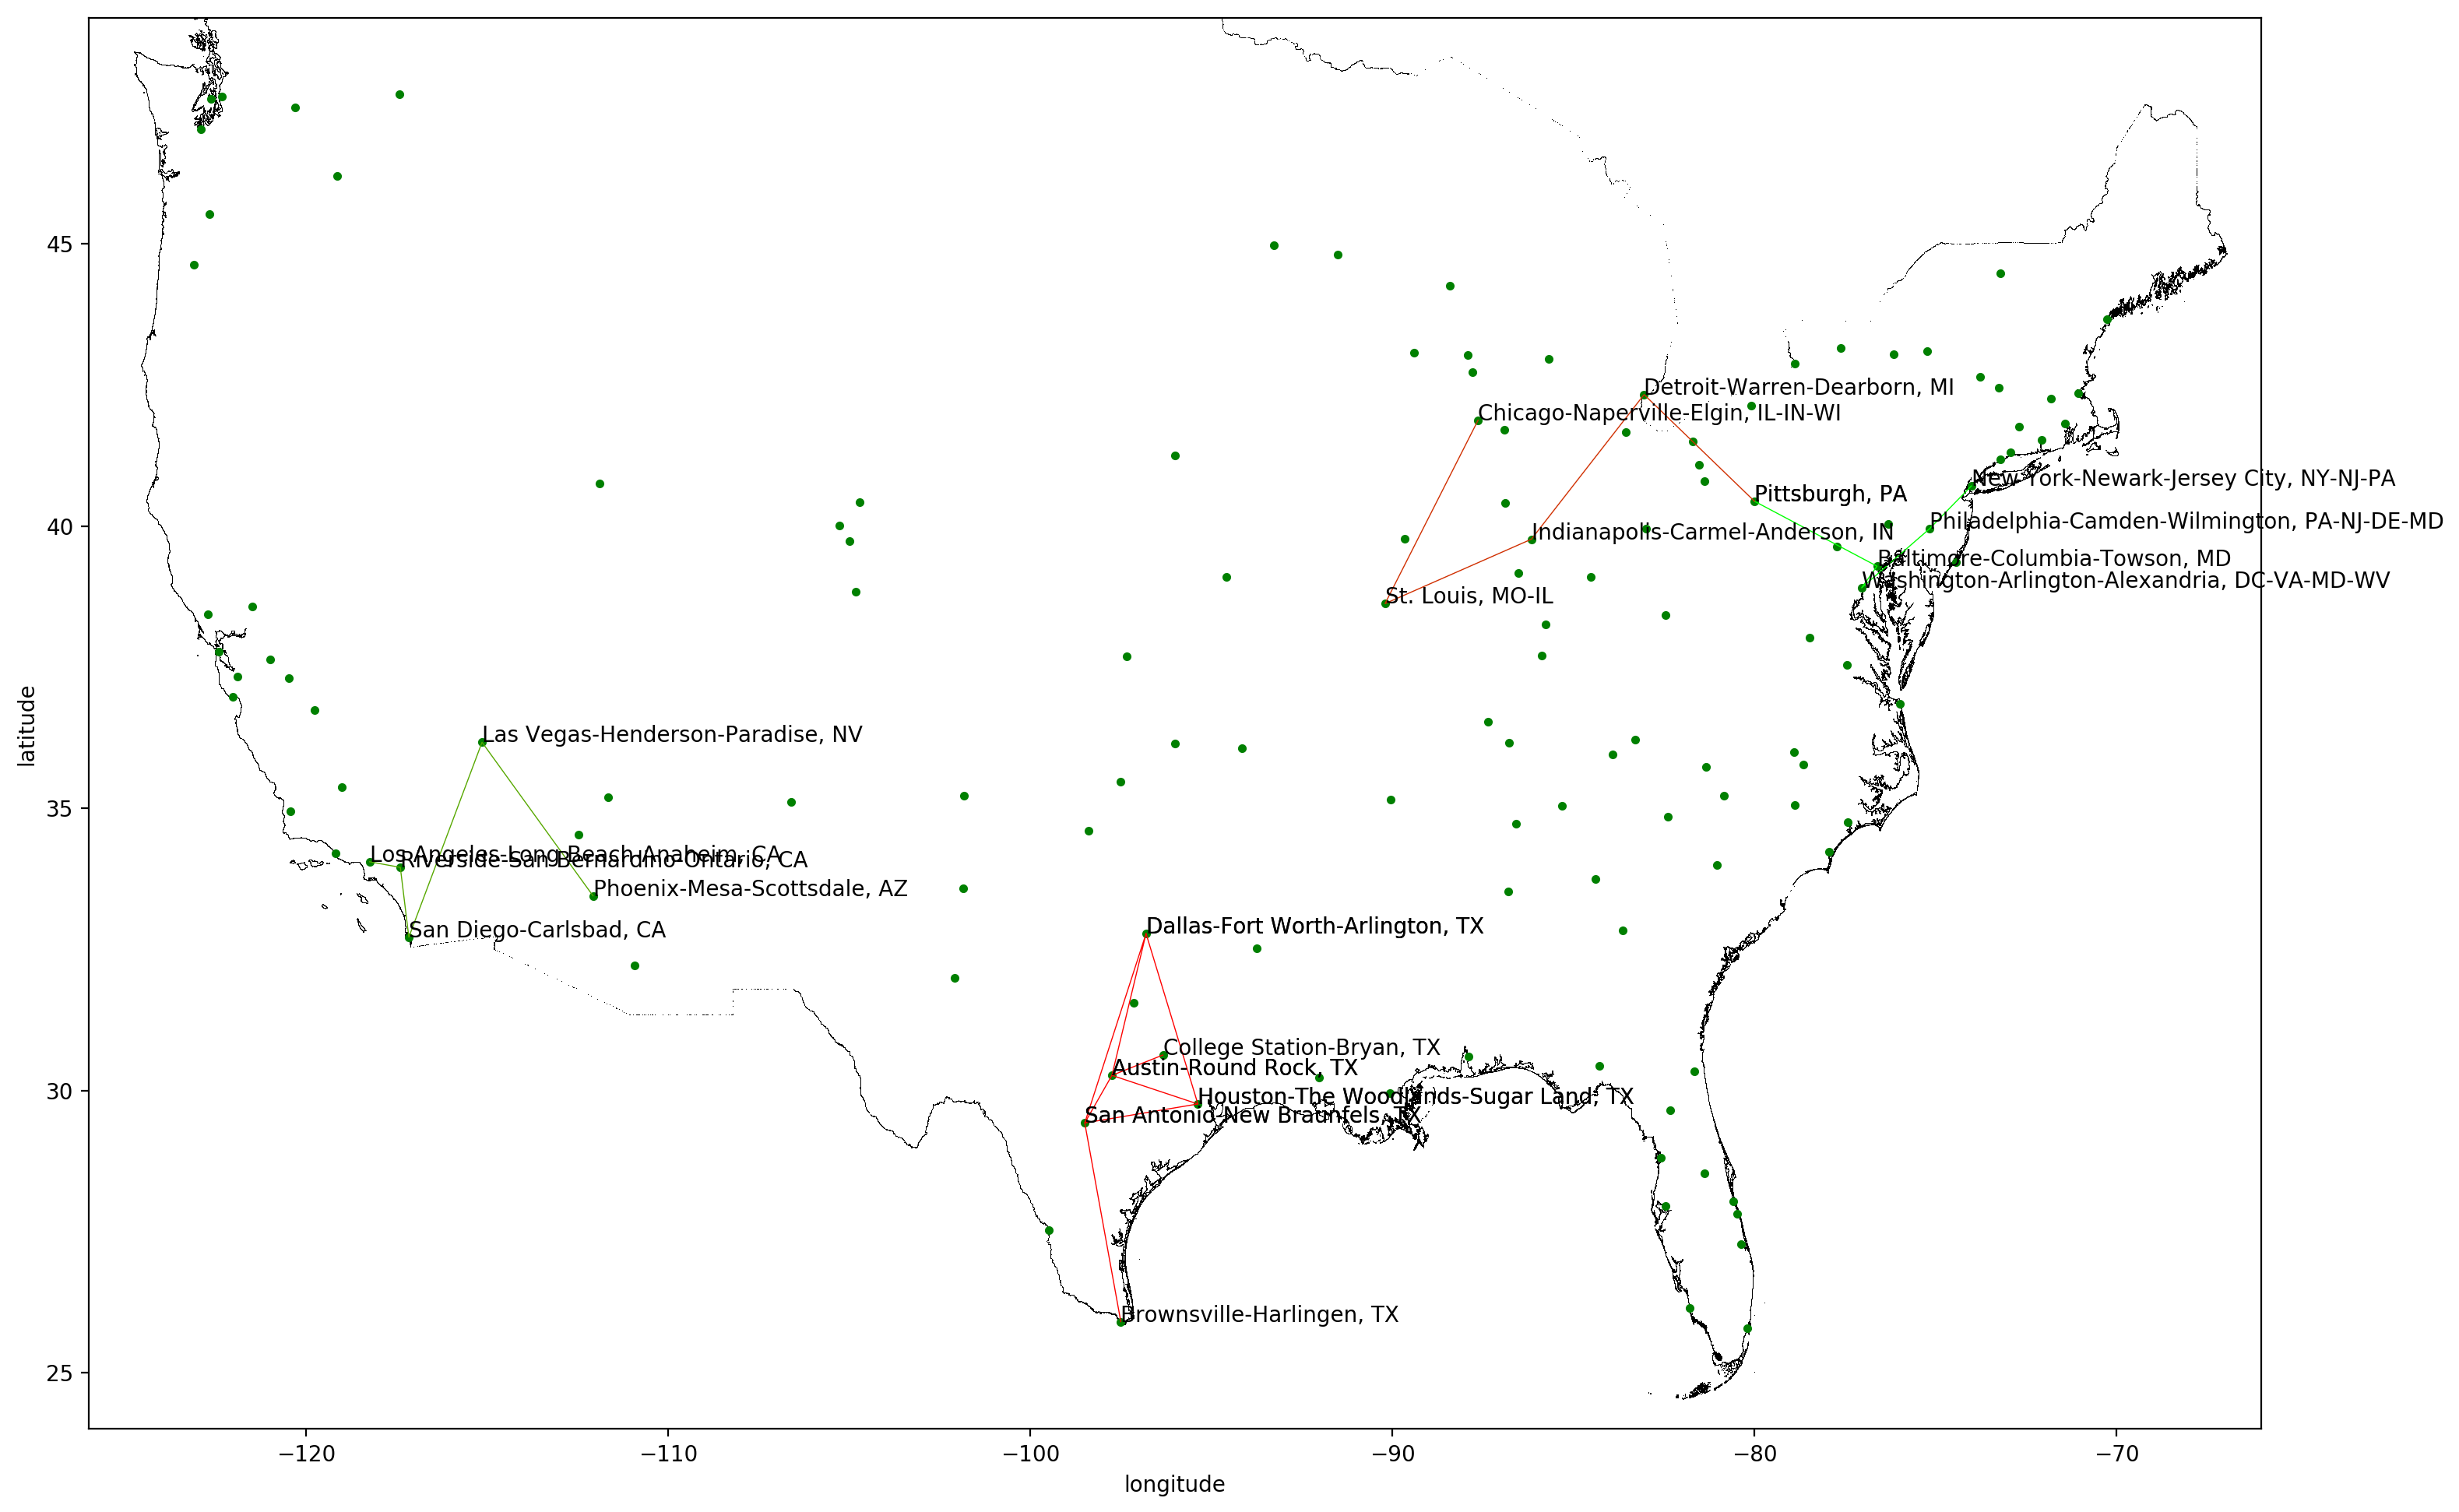

In [7]:
plt.figure(1,figsize=(18, 12), dpi= 200, facecolor='w', edgecolor='k')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(-126 ,-66)
plt.ylim(24,49)
plt.plot(USA[:,0].T,USA[:,1].T,'k,')
plt.plot(cities_xy[:,0],cities_xy[:,1],'g.')
#for i in np.arange(np.size(cities_names)):
#    plt.text(cities_xy[i,0],cities_xy[i,1], cities_names[i], fontsize=5)
for i in np.arange(trackn):
    plt.plot(cities_xy[tracks[i,:],0],cities_xy[tracks[i,:],1],'-',color=(score[i], 1-score[i], 0),linewidth=.5,label=str(i))

for i in np.arange(np.size(tracks)):
    n = tracks.flatten()[i]
    plt.text(cities_xy[n,0],cities_xy[n,1], cities_names[n], fontsize=10)
plt.show()

In [8]:
    
traveled = np.zeros(trackn)

for i in np.arange(trackn):
    for j in np.arange(linkage-1):
        traveled[i] += cities_distances_mi[tracks[i,j],tracks[i,j+1]]
        
stops = {}
for i in np.arange(trackn):
    for j in np.arange(linkage):
        stops[i,j] = cities_names[tracks[i,j]]


IndentationError: expected an indented block (<ipython-input-8-d60430e8381d>, line 5)

 New heading